# GWFish Tutorial
This is a brief guide on how to use GWFish software

##  Settings for working in Google Colab
In Google Colab you do not need to download anything locally, and can work online. The only requirement is to have a Google account. Once you have opened this tutorial in Google Colab, uncomment the following lines:

In [1]:
#! pip install -q git+https://github.com/janosch314/GWFish.git
#! pip install -q lalsuite
#! pip install -q corner

**Note**: in Google Colab remember to **restart the kernel runtime** after installation: `runtime -> restart session`

## Settings for working locally with GWFish

### Install GWFish in a `conda` environment
It is advisable to create a `conda` environment where to make the GWFish modules available
```
conda create --name gwfish_env python=3.9
conda activate gwfish_env
```
To make GWFish modules available from any location in your PC, after clonig the repository
```
git clone git@github.com:janosch314/GWFish.git
```
from the folder location, and after activating the `conda` environment, execute the command
```
pip install .
```
The following packages need to be installed as well:
```
pip install lalsuite
pip install corner
pip install tqdm
pip install pandas
pip install tables
pip install json
pip install os
pip install sympy
```
For `numpy` it is preferred to have a version below 2.0; since it is usually automatically installed with the conda environment, the suggestion is to uninstall it if the versione is $\ge 2$ and downgrade it:
```
pip uninstall numpy
pip install numpy==1.25
```

# What is the code about
`GWFish` is a Fisher matrix code, useful to calculate the covariance matrix for a gravitational wave (GW) event in a really small amout of computational time (around seconds). Let's take a step back and briefly recap how parameter estimation (PE) is done in the GW field.

## Starter: GW data analysis
Bayesian gravitational wave data analysis is used to infer the properties of gravitational wave sources and make predictions about their parameters (see below what are in detail the parameters we are talking about). It combines the principles of Bayesian statistics with the analysis of gravitational wave signals detected by ground-based observatories like LIGO and Virgo.

The goal of Bayesian gravitational wave data analysis is to extract this information from the noisy gravitational wave signals detected by the observatories:
$$s(t) = h_0(t) + n(t)$$
where $h_0(t)$ is the true (unknown) signal and $n(t)$ is the detector noise, assumed to be Gaussian and stationary.

Mathematically, Bayes' theorem can be expressed as:

$$p(\vec{\theta}|s) \propto \pi(\vec{\theta}){\mathcal{L}}(s|\vec{\theta})$$

where $p(\vec{\theta}|d)$ is the posterior distribution, ${\mathcal{L}}(d|\vec{\theta})$ is the likelihood function, $\pi(\vec{\theta})$ is the prior distribution, and we neglected the evidence or marginal likelihood at the denominator.

To perform Bayesian gravitational wave data analysis, we use various techniques such as Markov Chain Monte Carlo (MCMC) sampling and nested sampling. The mostly used software is `bilby`, and typically full Baysian parameter estimation is computationally expensive.

## Fisher-matrix approximation

The gravitational-wave likelihood is defined as the probability of noise realization:

$$ {\mathcal{L}}(d|\vec{\theta}) \propto \exp\left[-\frac{1}{2}\langle s - h(\vec{\theta})| s - h(\vec{\theta}) \rangle \right] $$

The inner product $\langle \cdot|\cdot\rangle$ measures the overlap between two signals given the noise characteristics of the detector:

$$ \langle a, b \rangle \equiv 4\operatorname{Re}\int_{f_{\rm min}}^{f_{\rm max}} \frac{\tilde{a}(f)\tilde{b}^*(f)}{S_n(f)}df $$

We can approximate the likelihood by expanding the template around the true signal:

$$ h(\vec{\theta})  = h_0 + \Delta \theta^i h_i$$

so that the likelihood becomes a **multivariarte Gaussian distribution**:

$$ p(\vec{\theta}|s)\propto \pi(\vec{\theta}) \exp\left[-\frac{1}{2}\langle n|n\rangle + \Delta \theta^k\langle n|h_k\rangle - \frac{1}{2}\Delta \theta^i \langle h_i|h_j\rangle \Delta \theta^j \right] $$

1. The truncation in the expansion is done at first-order in partial derivatives, known as **linearized signal approximation** (LSA)
2. LSA approximation is equivalent to the leading term in **posterior expansion as a series in 1/SNR** (this is the reason why Fisher matrix is said to work in high-SNR limit) [see Vallisneri 2008]

In Fisher matrix context we usually work in zero-noise approximation, so that the first two terms cancel and we define the Fisher matrix as:
$$ F_{ij} = \langle h_i|h_j\rangle$$


The Fisher likelihood is therefore simply given by:

$$ {\mathcal{L}} \propto \exp\left[-\frac{1}{2} \left(\vec{\theta} - \vec{\theta}_{\rm inj}\right)^{\rm T} F \left(\vec{\theta} - \vec{\theta}_{\rm inj}\right) \right] $$

The inverse of the Fisher matrix gives us the covariance matrix among parameters:

$$ \sigma_i = \sqrt{\Sigma_{ii}} \ \leftrightarrow  \Sigma_{ij} = \left[F^{-1}\right]_{ij}$$

This is the basic math behind Fisher matrix codes, like `GWFish`

### GW parameters
The parameters describind a GW event are the following (they are already provided with the same nomenclature as used in the code):
- `chirp_mass`: chirp mass of the binary in [Msol] (in detector frame)
- `mass_ratio`: ratio of the secondary mass over the primary mass, so that it ranges in $[0,1]$
- `redshift`: the redshift of the merger
- `luminosity_distance`:  the luminosity distance of the merger in [Mpc]
- `theta_jn`: the angle between the line of observation and the total angular momentum (orbital, spin and GR corrections) of the binary [rad] (it reduces to the so-called inclination angle or iota if the spin component is absent); it ranges in $[0, \pi]$
- `dec`: declination angle in [rad], it varies in $[-\pi/2, +\pi/2]$
- `ra`: right ascension in [rad], it varies in $[0, 2/pi]$
- `psi`: the polarization angle in [rad]; it ranges in $[0, \pi]$
- `phase`: the initial phase of the merger in [rad]; it ranges in $[0, 2\pi]$
- `geocent_time`: merger time as GPS time in [s]; it starts from 1980
- `a_1`: dimensionless spin parameter of primary component; it ranges in $[0, 1]$
- `a_2`: dimensionless spin parameter of secondary component; it ranges in $[0, 1]$
- `tilt_1`: zenith angle between the spin and orbital angular momenta for the primary component in [rad]; it ranges in $[0, \pi]$
- `tilt_2`: zenith angle between the spin and orbital angular momenta for the secondary component in [rad]; it ranges in $[0, \pi]$
- `phi_12`: difference between total and orbital angular momentum azimuthal angles in [rad]; it ranges in $[0, 2\pi]$
- `phi_jl`: difference between the azimuthal angles of the individual spin vector projections on to the orbital plane in [rad]; it ranges in $[0, 2\pi]$
- `lambda_1`: dimensionless tidal polarizabilty of primary component
- `lambda_2`: dimensionless tidal polarizabilty of secondary component

The `lambda_1` and `lambda_2` parameters are for neutron stars only and their value spans from a few hundreds to a thousand.

If $m_1$ and $m_2$ are the individual masses, then the chrip mass is defined as
$$ {\mathcal{M}}_{\rm chirp} = \frac{\left(m_1 m_2\right)^{3/5}}{\left(m_1 + m_2\right)^{1/5}} $$

## Why Fisher analysis?
**When studying the performance of a new detector, such as the Einstein Telescope, which has a much improved sensitivity and is predicted to detect entire populations of events ($10^6$ events per years against the current tens that we are detecting), we want a tool to make forecasts in a reasonable amoiunt of time. Since we do not have still a fast full parameter estimation, the Fisher matrix approximation is the state-of-the-art for forecasts.** 

# Let's start!

The implementation of a Fisher matrix code relies on three main pillars:
1. Analytic **waveform approximation**: `GWFish` uses all the waveforms from `lalsimulation` in frequency domain (although it is also possble to work in time domain)
2. **Derivatives**: these are done numerically at the second order (except for some parameters, like distance, phase and time, which are straightforward analytically)
3. **Matrix inversion**: singular value decomposition and normalization is used to safely invert the Fisher matrix

### Import packages

In [2]:
# suppress warning outputs for using lal in jupuyter notebook
import warnings 
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import GWFish.modules as gw
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import corner
import numpy as np
import pandas as pd
import json
import os
from astropy.cosmology import Planck18

## Single Event Analysis: GW170817-like

In [3]:
# Event's parameters should be passed as Pandas dataframe

parameters = {
    'chirp_mass': np.array([1.1858999987203738]) * (1 + 0.00980), 
    'mass_ratio': np.array([0.8308538032620448]), 
    'luminosity_distance': Planck18.luminosity_distance(0.00980).value,
    'theta_jn': np.array([2.545065595974997]),
    'ra': np.array([3.4461599999999994]),
    'dec': np.array([-0.4080839999999999]),
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1187008882.4]),
    'a_1':np.array([0.005136138323169717]), 
    'a_2':np.array([0.003235146993487445]), 
    'lambda_1':np.array([368.17802383555687]), 
    'lambda_2':np.array([586.5487031450857])}
parameters = pd.DataFrame(parameters)
parameters

,chirp_mass,mass_ratio,luminosity_distance,theta_jn,ra,dec,psi,phase,geocent_time,a_1,a_2,lambda_1,lambda_2
0,1.197522,0.830854,43.747554,2.545066,3.44616,-0.408084,0.0,0.0,1.187009e+09,0.005136,0.003235,368.178024,586.548703


In [4]:
# We choose a waveform approximant suitable for BNS analysis
# In this case we are taking into account tidal polarizability effects
waveform_model = 'IMRPhenomD_NRTidalv2'

## Play with the signal

In [5]:
# To access the available detectors, use the following command
gw.utilities.get_available_detectors()

dict_keys(['ET', 'VOY', 'CE1', 'CE2', 'LLO', 'LHO', 'VIR', 'VIR_O2', 'KAG', 'LIN', 'LISA', 'LGWA', 'LGWA_Nb', 'LGWA_Soundcheck'])

### Plot the signal
Let's start getting a feeling of how the signal appears

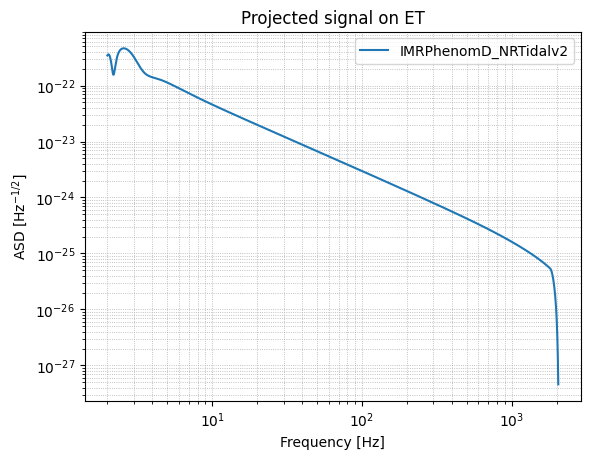

In [6]:
# Choose the detector onto which you want to project the signal
detector = 'ET'

# The following function outputs the signal projected onto the chosen detector
signal, _ = gw.utilities.get_fd_signal(parameters, detector, waveform_model)
frequency = gw.detection.Detector(detector).frequencyvector[:, 0]
# This signal has three components since ET comprises three detectors, let's plot one of them
plt.loglog(frequency, np.abs(signal[:, 0]), label='%s' %waveform_model)
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [Hz$^{-1/2}$]')
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
plt.title('Projected signal on %s' %detector)
plt.show()

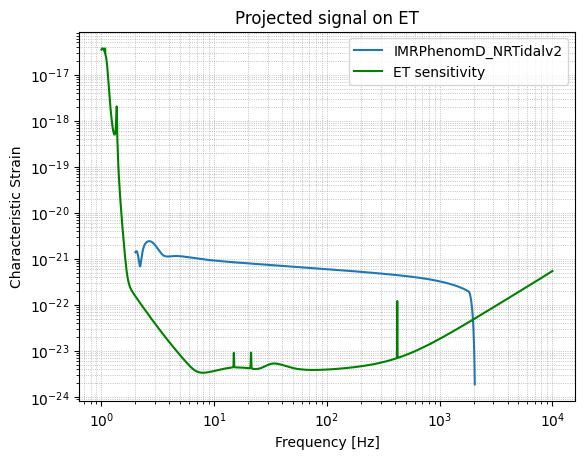

In [7]:
# add the detector's sensitivity curve and plot the characteristic strain
psd_data = gw.utilities.get_detector_psd(detector)
# psd_data is a dictionary with the keys 'frequency' and 'psd'

plt.loglog(frequency, 2 * frequency * np.abs(signal[:, 0]), label='%s' %waveform_model)
plt.loglog(psd_data[:, 0], np.sqrt(psd_data[:, 0] * psd_data[:, 1]), label='%s sensitivity' %detector, color='green')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain')
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
plt.title('Projected signal on %s' %detector)
plt.show()

### Characteristic strain
The characteristic strain is a particular combination of signal/ASD with frequency so that the output is adimensional and the area in between the signal and the detector's densitivity curve can be interpreted as SNR:

$$
SNR^2 = 4\int\frac{h(f)h^*(f)}{S_n}df
$$

Therefore:

$$
h_c = 2f|h| \quad \text{and} \quad S_c = \sqrt{f}\sqrt{PSD}
$$

In [8]:
# Plot the time before the merger as a function of the frequency
_, t_of_f = gw.utilities.get_fd_signal(parameters, detector, waveform_model)


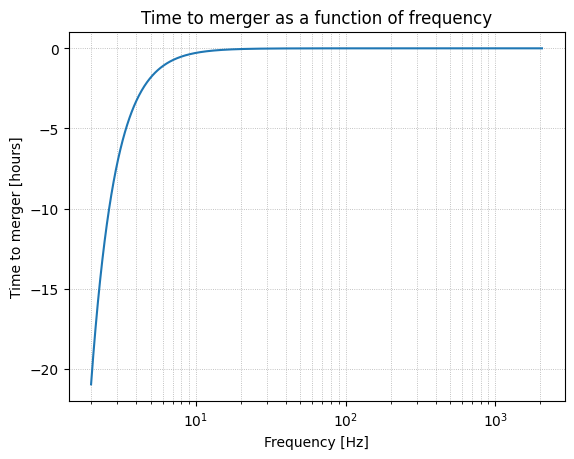

In [9]:
convert_from_seconds_to_hours = 3600
plt.semilogx(frequency, (t_of_f - parameters['geocent_time'].iloc[0]) / convert_from_seconds_to_hours)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Time to merger [hours]')
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
plt.title('Time to merger as a function of frequency')
plt.show()

## Calculate SNR

In [10]:
# The networks are the combinations of detectors that will be used for the analysis
# The detection_SNR is the minimum SNR for a detection:
#   --> The first entry specifies the minimum SNR for a detection in a single detector
#   --> The second entry specifies the minimum network SNR for a detection
detectors = ['ET', 'CE1', 'LLO', 'LHO', 'VIR']
network = gw.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
snr = gw.utilities.get_snr(parameters, network, waveform_model)


In [11]:
snr

{'ET': 636.2157090152681,
 'CE1': 1126.071930553518,
 'LLO': 85.46494067544035,
 'LHO': 101.09582988399292,
 'VIR': 27.422188574022986,
 'network': 1300.4172486202676}

## Calculate $1\sigma$ Errors
For a more realistic analysis we can include the **duty cycle** of the detectors using `use_duty_cycle = True`

In [12]:
# The fisher parameters are the parameters that will be used to calculate the Fisher matrix
# and on which we will calculate the errors
fisher_parameters = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn', 'dec','ra',
                     'psi', 'phase', 'geocent_time', 'a_1', 'a_2', 'lambda_1', 'lambda_2']

In [13]:
detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network = gw.detection.Network(detector_ids = ['ET'], detection_SNR = (0., 8.)),
        parameter_values = parameters,
        fisher_parameters=fisher_parameters, 
        waveform_model = waveform_model
        )   
        # use_duty_cycle = False, # default is False anyway
        # save_matrices = False, # default is False anyway, put True if you want Fisher and covariance matrices in the output
        # save_matrices_path = None, # default is None anyway,
                                     # otherwise specify the folder
                                     # where to save the Fisher and
                                     # corresponding covariance matrices
    


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


In [14]:
print('The network SNR of the event is ', network_snr)

The network SNR of the event is  [636.21570902]


In [15]:
print('The sky localization of the event is ', sky_localization)

The sky localization of the event is  [3.64116385e-05]


In [16]:
# Choose percentile factor of sky localization and pass from rad2 to deg2
percentile = 90.
sky_localization_90cl = sky_localization * gw.fishermatrix.sky_localization_percentile_factor(percentile)
sky_localization_90cl

array([0.55046685])

In [17]:
# One can create a dictionary with the parameter errors, the order is the same as the one given in fisher_parameters
parameter_errors_dict = {}
for i, parameter in enumerate(fisher_parameters):
    parameter_errors_dict['err_' + parameter] = np.squeeze(parameter_errors)[i]

print('The parameter errors of the event are ')
parameter_errors_dict

The parameter errors of the event are 


{'err_chirp_mass': 1.6062810243474914e-07,
 'err_mass_ratio': 0.0028025221674680845,
 'err_luminosity_distance': 2.0132724161959694,
 'err_theta_jn': 0.07052968834443957,
 'err_dec': 0.0032711249839363138,
 'err_ra': 0.003861136998668321,
 'err_psi': 0.11893991843831235,
 'err_phase': 0.24017319905107357,
 'err_geocent_time': 8.424847346623735e-05,
 'err_a_1': 0.10270419800750145,
 'err_a_2': 0.12833752882750646,
 'err_lambda_1': 4315.711657916377,
 'err_lambda_2': 7764.761787638582}

## Save results to file

There is another function ```analyze_and_save_to_txt``` that allows to save the results to a file. The difference with respect to the ```compute_network_errors``` function is that one can pass different network combinations and get results files for each of them. This means that if your detectors list is something like ```['LHO', 'LLO', 'VIR', 'CE1', 'ET']``` and you want to create 3 different networks out of it, i.e. ```['LHO', 'LLO', 'VIR']```, ```['CE1', 'ET']``` and ```['ET']``` alone, then one should inizialize the ```analyze_and_save_to_txt``` function as follows:

```
network = gw.detection.Network(detector_ids = ['LHO', 'LLO', 'VIR', 'CE1', 'ET'], detection_SNR = (0., 8.))
```

and then specify the different network combinations:

```
sub_network_ids_list = [[0, 1, 2], [3, 4], [4]]
```

In [18]:
# create forlder where store results
!mkdir tutorial_results

mkdir: tutorial_results: File exists


In [19]:
data_folder = 'tutorial_results' # the one we just created
network = gw.detection.Network(detector_ids = ['ET'], detection_SNR = (0., 8.))
gw.fishermatrix.analyze_and_save_to_txt(network = network,
                                        parameter_values  = parameters,
                                        fisher_parameters = fisher_parameters, 
                                        sub_network_ids_list = [[0]],
                                        population_name = 'BNS',
                                        waveform_model = waveform_model,
                                        save_path = data_folder,
                                        save_matrices = True)

100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


In [20]:
fisher_matrix = np.load(data_folder + '/' + 'fisher_matrices_ET_BNS_SNR8.npy')

In [21]:
errors = pd.read_csv(data_folder + '/' + 'Errors_ET_BNS_SNR8.txt', delimiter = ' ')

In [22]:
# One can access all the column names of the errors output file:
errors.keys()

Index(['network_SNR', 'chirp_mass', 'mass_ratio', 'luminosity_distance',
       'theta_jn', 'ra', 'dec', 'psi', 'phase', 'geocent_time', 'a_1', 'a_2',
       'lambda_1', 'lambda_2', 'err_chirp_mass', 'err_mass_ratio',
       'err_luminosity_distance', 'err_theta_jn', 'err_dec', 'err_ra',
       'err_psi', 'err_phase', 'err_geocent_time', 'err_a_1', 'err_a_2',
       'err_lambda_1', 'err_lambda_2', 'err_sky_location'],
      dtype='object')

Same errors as before just save to a .txt file:

In [23]:
errors

,network_SNR,chirp_mass,mass_ratio,luminosity_distance,theta_jn,ra,dec,psi,phase,geocent_time,...,err_dec,err_ra,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_lambda_1,err_lambda_2,err_sky_location
0,636.215709,1.198,0.8309,43.75,2.545,3.446,-0.4081,0.0,0.0,1.187000e+09,...,0.003271,0.003861,0.1189,0.2402,0.000084,0.1027,0.1283,4316.0,7765.0,0.000036


### A quick test

One would expect that the Fisher matrix entry corresponding to dL-dL should be approximated by the ratio between the SNR and the luminosity distance squared as follows:

$$
\frac{1}{SNR} = \frac{\Delta d_L}{d_L}
$$

where $\Delta d_L = \sqrt{\left[F\right]^{-1}_{d_L,d_L}}$, with $F$ the Fisher matrix.

This can be derived from the fact that $\partial_{d_L}h = -\frac{1}{d_L}h$ and 
$$\frac{1}{\left(\Delta d_L\right)^2} \sim F_{d_L,d_L}=\langle \partial_{d_L}h|\partial_{d_L}h\rangle \sim \frac{SNR^2}{d_L^2}$$

where the inverse of the error on distance is the corresponding entry of the Fisher matrix $F_{d_L,d_L}$ (assuming correlations are negligible).

A rough approximation in literature takes: $\frac{\Delta d_L}{d_L} \sim \frac{2}{SNR}$.

In [24]:
my_fisher = fisher_matrix[0, :, :]
print('We expect Delta dL/dL to scale as 1/SNR')
print('fisher matrix dL-dL: ', my_fisher[2, 2])
print('(SNR/dL)^2: ', (errors['network_SNR'].iloc[0] / errors['luminosity_distance'].iloc[0])**2)

We expect Delta dL/dL to scale as 1/SNR
fisher matrix dL-dL:  211.4955409805775
(SNR/dL)^2:  211.47189728538135


## Corner plot

Using the covariance matrix one show all the correlations between pairs of parameters in a corner plot. Using as inputs the injected values and the covariance matrix, one samples from a multivariate Gaussian distribution and plot the samples.

In [25]:
CORNER_KWARGS = dict(
    bins = 50, # number of bins for histograms
    smooth = 0.99, # smooths out contours. 
    plot_datapoints = True, # choose if you want datapoints
    label_kwargs = dict(fontsize = 12), # font size for labels
    show_titles = True, #choose if you want titles on top of densities.
    title_kwargs = dict(fontsize = 12), # font size for title
    plot_density = False,
    title_quantiles = [0.16, 0.5, 0.84],  # add quantiles to plot densities for 1d hist
    levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), # 1, 2 and 3 sigma contours for 2d plots
    fill_contours = True, #decide if you want to fill the contours
    max_n_ticks = 2, # set a limit to ticks in the x-y axes.
    title_fmt=".3f"
    )

In [26]:
corner_lbs = [r'${\mathcal{M}}_{\rm chirp}$ $[M_{\odot}]$', r'$q$', r'$D_{\rm L}$ [Mpc]',
                r'$\iota$ [rad]', r'$DEC$ [rad]', r'$RA$ [rad]', r'$\Psi$ [rad]',
                r'$phase$', r'$t_c$ [s]', r'$a_1$', r'$a_2$', r'$\Lambda_1$', r'$\Lambda_2$']

mean_lbs = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn', 'dec', 'ra', 'psi',
            'phase', 'geocent_time', 'a_1', 'a_2', 'lambda_1', 'lambda_2']
mean_values = parameters[mean_lbs].iloc[0] # mean values of the parameters
cov_matrix = np.load(data_folder + '/' + 'inv_fisher_matrices_ET_BNS_SNR8.npy')[0, :, :]

/Users/ulyana/miniconda3/envs/python_env/lib/python3.10/site-packages/corner/core.py:841: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if xs[k1] is not None:
/Users/ulyana/miniconda3/envs/python_env/lib/python3.10/site-packages/corner/core.py:842: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[k1, k1].axvline(xs[k1], **kwargs)
/Users/ulyana/miniconda3/envs/python_env/lib/python3.10/site-packages/corner/core.py:844: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

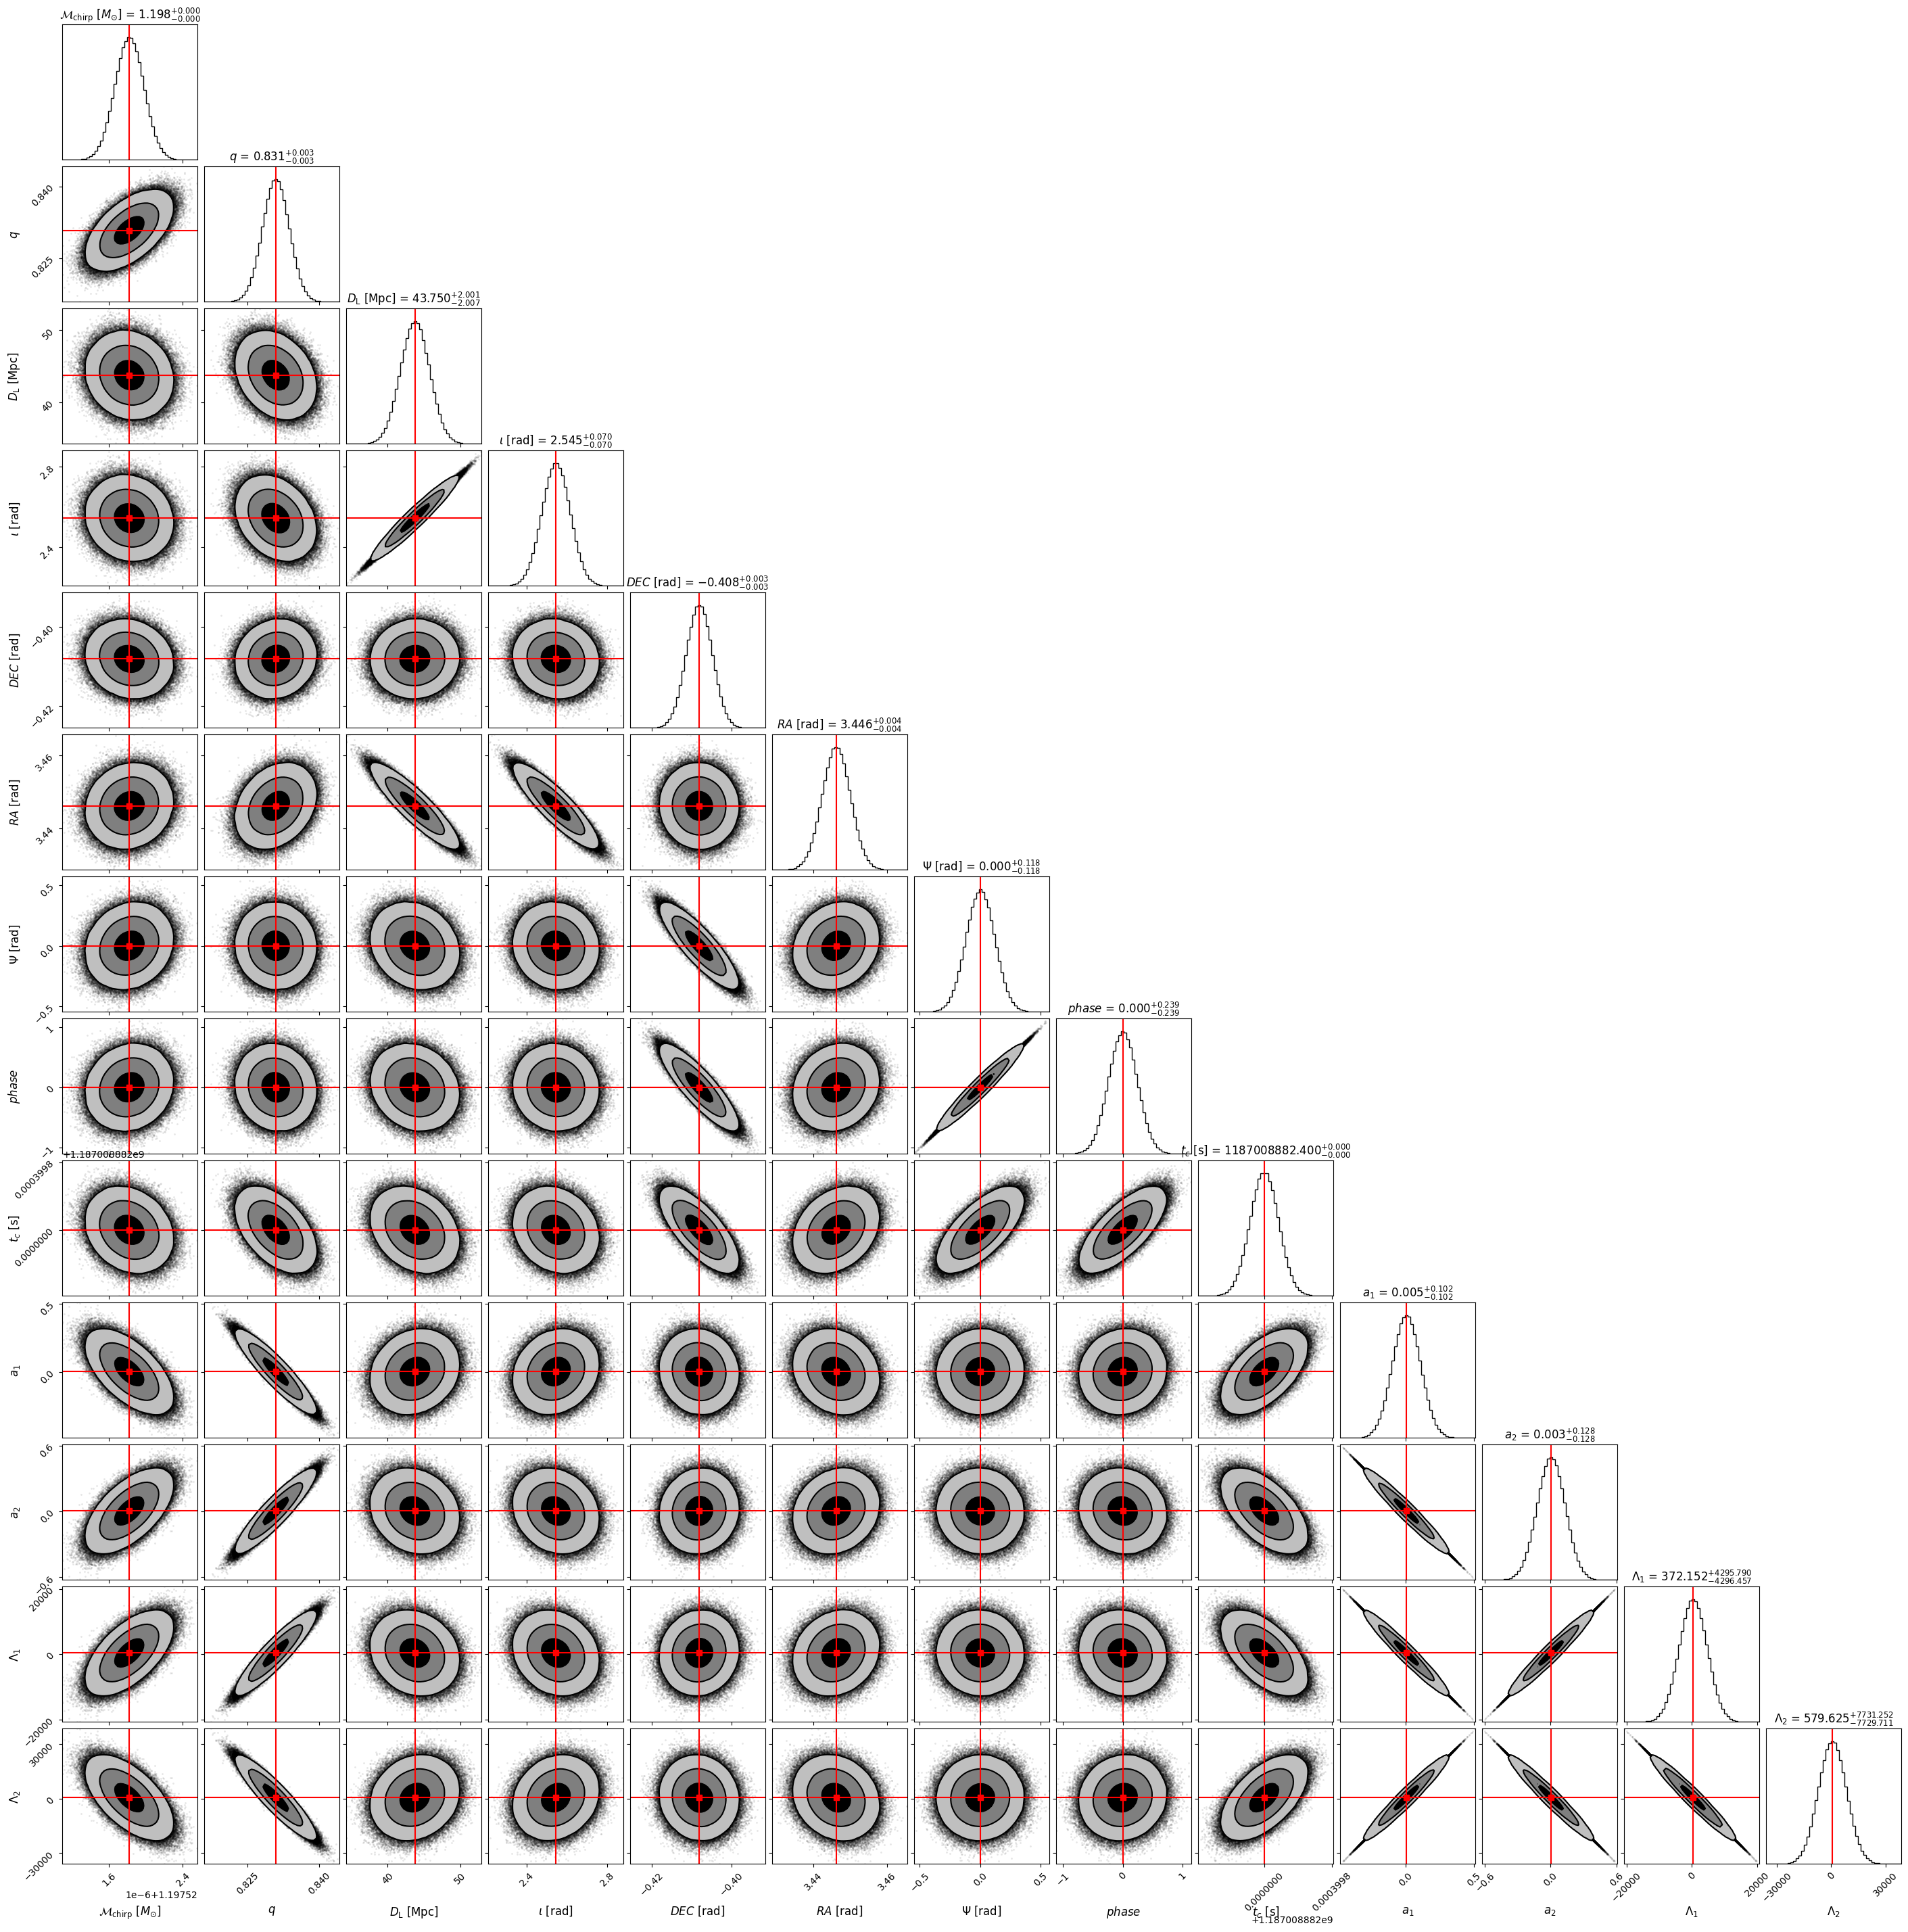

In [27]:
# Sample from a multi-variate gaussian with the given covariance matrix and injected mean values
samples = np.random.multivariate_normal(mean_values, cov_matrix, int(1e6))
fig = corner.corner(samples, labels = corner_lbs, truths = mean_values, truth_color = 'red',
                    **CORNER_KWARGS)
plt.show()

## Some exercises

### 1. Compare waveforms
Take the GW170817-like event we have analyzed so far and try to compare the error estimate using two different waveforms (for example the basic TaylorF2 and the IMRPhenomHM)

### 2. Compare networks
Take our GW17817-like event and compare results using ET alone and the O5-like network composed of LIGO-Hanford (LHO), LIGO Livingston (LLO), Virgo (VIR) and KAGRA (KAG). What happens to sky localization?

### A quick note on detectors setup

Detectors are all described in the ```.yaml``` file. The general settings are as follows (in case you want to customize your own detector):

```
ET: # name label of the detector
            lat:              (40 + 31. / 60 ) * np.pi / 180.
            lon:              (9 + 25. / 60) * np.pi / 180.
            opening_angle:    np.pi / 3.
            azimuth:          70.5674 * np.pi / 180.
            psd_data:         ET_psd.txt # file containg two columns: frequency, psd
            duty_factor:      0.85
            detector_class:   earthDelta # for triangle-shaped detector or earthL if usual-shape detector
            plotrange:        3, 1000, 1e-25, 1e-20
            fmin:             2. # minimum frequency of the detector
            fmax:             2048. # maximum frequency of the detector
            spacing:          geometric
            df:               1./16.
            npoints:          1000
```

The ```spacing``` variable can either be ```geometric``` (logarithmic spacing of the frequency vector for waveform evaluation with a number of points specified by the ```npoints``` variable, faster solution) or ```linear``` (linear spacing of the frequency vector to evaluate the waveform with spacing given by ```df```, slower solution)

# Population Analysis
The functions are the same explained in the previous tutorial, but applied to a population sample instead of a single event

In [28]:
# Example for BNS population
nev = 50 # number of events
my_dict = {}
my_dict['redshift'] = np.random.uniform(0.001, 1, nev)
my_dict['mass_1'] = np.random.uniform(1.1, 2.5, nev)
my_dict['mass_2'] = np.random.uniform(1.1, 2.5, nev)
my_dict['luminosity_distance'] = Planck18.luminosity_distance(my_dict['redshift']).value
my_dict['theta_jn'] = np.arccos(np.random.uniform(-1., 1., nev))
my_dict['ra'] = np.random.uniform(0., 2 * np.pi, nev)
my_dict['dec'] = np.arcsin(np.random.uniform(-1., 1., nev))
my_dict['psi'] = np.random.uniform(0., np.pi, nev)
my_dict['phase'] = np.random.uniform(0., 2 * np.pi, nev)
my_dict['geocent_time'] = np.random.uniform(1577491218, 1609027217, nev)
my_dict['a_1'] = np.random.uniform(0., 0.1, nev)
my_dict['a_2'] = np.random.uniform(0., 0.1, nev)


aux_mass = my_dict['mass_1'] # sort the two masses so that m1>m2
my_dict['mass_1'] = np.maximum(aux_mass, my_dict['mass_2'])
my_dict['mass_2'] = np.minimum(aux_mass, my_dict['mass_2'])
my_pop = pd.DataFrame(my_dict)
my_pop.head(5)

,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,geocent_time,a_1,a_2
0,0.485980,1.455279,1.321403,2822.042495,2.056668,4.872108,-1.208710,2.757888,5.294343,1.609012e+09,0.002640,0.024790
1,0.049282,2.432759,1.221512,226.462100,1.603514,0.545339,0.425457,0.864239,2.500387,1.590733e+09,0.060086,0.058396
2,0.631246,2.428387,1.355342,3866.531579,0.801110,5.952386,-0.473933,0.275668,1.132954,1.588662e+09,0.024629,0.032791
3,0.916711,2.477565,1.898075,6101.790783,1.907115,4.143035,-0.702718,2.023658,0.765871,1.587211e+09,0.045681,0.014086
4,0.690307,1.990105,1.432973,4310.745251,1.348773,5.563656,0.495020,2.827020,1.667034,1.598847e+09,0.060834,0.016686


In [29]:
detectors_pop = ['ET']
network_pop = gw.detection.Network(detector_ids = detectors_pop, detection_SNR = (0., 8.))
waveform_model_pop = 'IMRPhenomHM'
fisher_parameters_pop = ['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'dec','ra',
                     'psi', 'phase', 'geocent_time', 'a_1', 'a_2']

In [30]:
!mkdir pop_gwfish_results

mkdir: pop_gwfish_results: File exists


In [31]:
data_folder_pop = 'pop_gwfish_results'
gw.fishermatrix.analyze_and_save_to_txt(network = network_pop,
                                        parameter_values  = my_pop,
                                        fisher_parameters = fisher_parameters_pop, 
                                        sub_network_ids_list = [[0]],
                                        population_name = 'BNS_POP',
                                        waveform_model = waveform_model_pop,
                                        save_path = data_folder_pop,
                                        save_matrices = False)

100%|██████████| 50/50 [00:15<00:00,  3.33it/s]


In [32]:
pop_errors = pd.read_csv(data_folder_pop + '/' + 'Errors_ET_BNS_POP_SNR8.txt', delimiter = ' ')
pop_errors.head(5)

,network_SNR,redshift,mass_1,mass_2,luminosity_distance,theta_jn,ra,dec,psi,phase,...,err_luminosity_distance,err_theta_jn,err_dec,err_ra,err_psi,err_phase,err_geocent_time,err_a_1,err_a_2,err_sky_location
0,11.092911,0.48600,1.455,1.321,2822.0,2.05700,4.8720,-1.2090,2.7580,5.294,...,2798.00,0.228600,0.78550,2.94200,2.86000,0.5829,0.014320,3.55600,4.00300,2.562000
1,114.125052,0.04928,2.433,1.222,226.5,1.60400,0.5453,0.4255,0.8642,2.500,...,24.94,0.004572,0.18590,0.13030,0.05903,0.0255,0.002267,0.03672,0.08534,0.049720
2,8.445482,0.63120,2.428,1.355,3867.0,0.80110,5.9520,-0.4739,0.2757,1.133,...,6281.00,1.956000,0.53810,0.45940,4.04300,7.9250,0.010640,0.62500,1.27700,0.674500
3,8.010933,0.46990,2.407,2.123,2711.0,1.06500,0.2860,1.0260,0.7440,0.159,...,6501.00,1.224000,0.29490,0.58570,1.21100,4.1110,0.006385,3.46700,4.04600,0.250300
4,28.130964,0.27200,2.026,1.971,1432.0,0.08201,4.4280,0.0788,2.2260,2.715,...,1435.00,12.160000,0.02348,0.02357,0.67600,1.4250,0.000600,5.15300,5.33000,0.001733


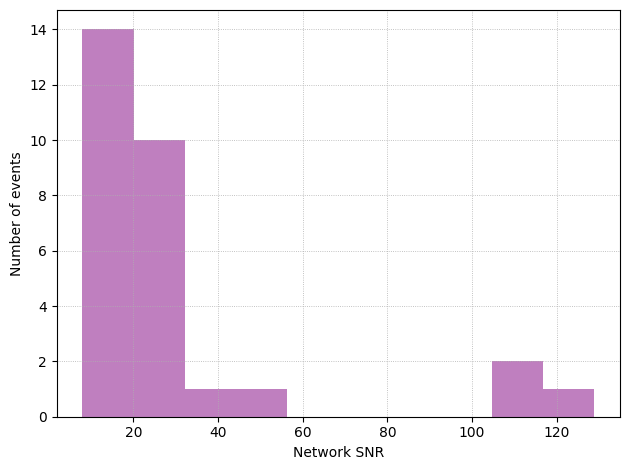

In [33]:
plt.hist(pop_errors['network_SNR'], bins = 10, color = 'purple', alpha = 0.5, linewidth = 2)
plt.xlabel('Network SNR')
plt.ylabel('Number of events')
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
plt.tight_layout()
plt.show()

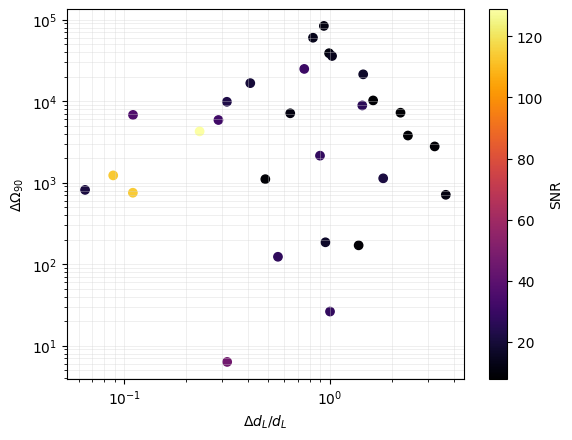

In [34]:
percentile_pop = 90
sky_loc_90cl_pop = pop_errors['err_sky_location'] * gw.fishermatrix.sky_localization_percentile_factor(percentile_pop)
sc = plt.scatter(pop_errors['err_luminosity_distance'] / pop_errors['luminosity_distance'],
                 sky_loc_90cl_pop, c = pop_errors['network_SNR'], cmap = 'inferno')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\Delta d_L/d_L$')
plt.ylabel('$\Delta \Omega_{%s}$' %int(percentile))
plt.colorbar(sc, label = 'SNR')
plt.grid(which = 'both', color = 'lightgray', alpha = 0.5, linewidth = 0.5)
plt.show()